In [4]:
import numpy as np
import pandas as pd
from numba import njit
from tqdm import trange
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
!wget -q --show-progress https://github.com/sparsh-ai/general-recsys/raw/T021355/FM/sms.tsv

sms.tsv             100%[===================>] 466.71K  --.-KB/s    in 0.04s   


In [3]:
# using the example spam dataset
# read it in, extract the input and output columns
label_col = 'label_num'
sms = pd.read_table('sms.tsv', header = None, names = ['label', 'message'])
sms[label_col] = sms['label'].map({'ham': 0, 'spam': 1})
X = sms['message']
y = sms[label_col].values

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 1)

# convert both sets' text column to document-term matrix;
# ideally, we would want to perform some preprocessing on
# our text data, but let's be lazy here as that's not
# the goal of this documentation
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5)
X_train_dtm = tfidf.fit_transform(X_train)
X_test_dtm = tfidf.transform(X_test)
X_train_dtm

<4179x3508 sparse matrix of type '<class 'numpy.float64'>'
	with 51261 stored elements in Compressed Sparse Row format>

In [5]:
class FactorizationMachineClassifier(BaseEstimator, ClassifierMixin):
    """
    Factorization Machine [1]_ using Stochastic Gradient Descent.
    For binary classification only.

    Parameters
    ----------
    n_iter : int, default 10
        Number of iterations to train the algorithm.

    n_factors : int, default 10
        Number/dimension of features' latent factors.

    learning_rate : float, default 0.1
        Learning rate for the gradient descent optimizer.

    reg_coef : float, default 0.01
        Regularization strength for weights/coefficients.

    reg_factors : float, default 0.01
        Regularization strength for features' latent factors.

    random_state : int, default 1234
        Seed for the randomly initialized features latent factors

    verbose : bool, default True
        Whether to print progress bar while training.

    Attributes
    ----------
    intercept_ : double
        Intercept term, w0 based on the original notations.

    coef_ : 1d ndarray, shape [n_features,]
        Coefficients, w based on the original notations.

    feature_factors_ : 2d ndarray, shape [n_factors, n_features]
        Latent factors for all features. v based on the original
        notations. The learned factors can be viewed as the
        embeddings for each features. If a pair of features tends
        to co-occur often, then their embeddings should be
        close/similar (in terms of cosine similarity) to each other.

    history_ : list
        Loss function's history at each iteration, useful
        for evaluating whether the algorithm converged or not.

    References
    ----------
    .. [1] `S. Rendle Factorization Machines (2010)
            <http://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf>`_ 
    """

    def __init__(self, n_iter = 10, n_factors = 10,
                 learning_rate = 0.1, reg_coef = 0.01,
                 reg_factors = 0.01, random_state = 1234, verbose = False):
        self.n_iter = n_iter
        self.verbose = verbose
        self.reg_coef = reg_coef
        self.n_factors = n_factors
        self.reg_factors = reg_factors
        self.random_state = random_state
        self.learning_rate = learning_rate

    def fit(self, X, y):
        """
        Fit the model to the input data and label.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        y : 1d ndarray, shape [n_samples,]
            Training data's corresponding label.

        Returns
        -------
        self
        """

        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0

        # the factors are often initialized with a mean of 0 and standard deviation
        # of 1 / sqrt(number of latent factor specified)
        np.random.seed(self.random_state)
        self.feature_factors_ = np.random.normal(
            scale = 1 / np.sqrt(self.n_factors), size = (self.n_factors, n_features))
        
        # the gradient is implemented in a way that requires
        # the negative class to be labeled as -1 instead of 0
        y = y.copy().astype(np.int32)
        y[y == 0] = -1

        loop = range(self.n_iter)
        if self.verbose:
            loop = trange(self.n_iter)

        self.history_ = []
        for _ in loop:
            loss = _sgd_update(X.data, X.indptr, X.indices,
                               y, n_samples, n_features,
                               self.intercept_, self.coef_,
                               self.feature_factors_, self.n_factors,
                               self.learning_rate, self.reg_coef, self.reg_factors)
            self.history_.append(loss)

        return self

    def predict_proba(self, X):
        """
        Probability estimates. The returned estimates for
        all classes are ordered by the label of classes.

        Paramters
        ---------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        proba : 2d ndarray, shape [n_samples, n_classes]
            The probability of the sample for each class in the model.
        """
        pred = self._predict(X)
        pred_proba = 1.0 / (1.0 + np.exp(-pred))
        proba = np.vstack((1 - pred_proba, pred_proba)).T
        return proba

    def _predict(self, X):
        """Similar to _predict_instance but vectorized for all samples"""
        linear_output = X * self.coef_
        v = self.feature_factors_.T
        term = (X * v) ** 2 - (X.power(2) * (v ** 2))
        factor_output = 0.5 * np.sum(term, axis = 1)
        return self.intercept_ + linear_output + factor_output

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        pred_proba = self.predict_proba(X)[:, 1]
        return pred_proba.round().astype(np.int)


@njit
def _sgd_update(data, indptr, indices, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    """
    Compute the loss of the current iteration and update
    gradients accordingly.
    """
    loss = 0.0
    for i in range(n_samples):
        pred, summed = _predict_instance(data, indptr, indices, w0, w, v, n_factors, i)
        
        # calculate loss and its gradient
        loss += _log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # update bias/intercept term
        w0 -= learning_rate * loss_gradient

        # update weight
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # update factor
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss


@njit
def _predict_instance(data, indptr, indices, w0, w, v, n_factors, i):
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])
    
    # summed is the independent term that can be re-used
    # during the gradient update stage
    return pred, summed


@njit
def _log_loss(pred, y):
    """
    negative log likelihood of the
    current prediction and label, y.
    """
    return np.log(np.exp(-pred * y) + 1.0)

In [6]:
fm = FactorizationMachineClassifier(n_iter = 30, learning_rate = 0.1)
fm.fit(X_train_dtm, y_train)

FactorizationMachineClassifier(n_iter=30)

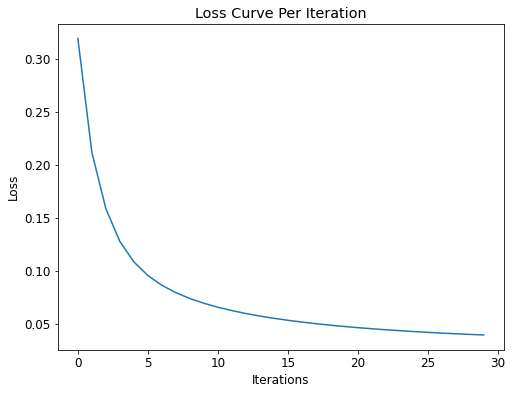

In [7]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# one quick way to check that we've implemented
# the gradient descent is to ensure that the loss
# curve is steadily decreasing
plt.plot(fm.history_)
plt.title('Loss Curve Per Iteration')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [8]:
# predict on the test set and output the auc score
y_pred_prob = fm.predict_proba(X_test_dtm)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('auc', auc)

auc 0.9973867907642743


In [9]:
# we can compare it with a logistic regression,
logreg = LogisticRegression()
logreg.fit(X_train_dtm, y_train)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('auc', auc)

auc 0.9950017898693396
